In [1]:
import os
import json
import itertools
from tqdm import tqdm
from tensorflow import keras
from IPython.display import clear_output
# from collections import Counter
# import time

# import matplotlib.pyplot as plt
# import numpy as np


# from pathlib import Path





from pattern.text.en import tokenize
from gensim.models import Word2Vec

C:\Users\zacharias.detorakis\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\image.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int):
C:\Users\zacharias.detorakis\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` he

In [2]:
import argparse

parser = argparse.ArgumentParser()

parser.add_argument(
    '--synthetic_column_size',
    type=int,
    default=10,
    help='Size of synthetic column')
parser.add_argument(
    '--sequence_size',
    type=int,
    default=50,
    help='Length of word sequence of synthetic column')
parser.add_argument(
    '--model_dir',
    type=str,
    default=os.path.abspath('C:/Users/zacharias.detorakis/Desktop/nov-city-ms-project/app/w2v_model/enwiki_model'),
#     default='/w2v_model/enwiki_model/',
    help='Directory of word2vec model')
FLAGS, unparsed = parser.parse_known_args()

In [3]:
# Path(os.getcwd()+"\output\cnn_models").mkdir(parents=True, exist_ok=True)

# Load input data

* data: Tabular data + ground truth
* dict_col_candidate_classes: a dictionary with filename_columns and in each of the an array of [(candidate_type, candidate_entity, original_cell_value, rank)]
* type_neighours_pos_neg_samples: a dictionary that is used to train the classifiers so for each candidate class we have the neighbouring classes, positive samples from the KG and positive and negative samples from the tabular data

In [4]:
# Load the dictionary with the lookup results for each cell value in the tabular data
def load_json(data_json):
    with open(data_json) as json_file:
        return json.load(json_file)

In [5]:
output_folder = 'output\\'
cnn_model_directory = os.getcwd()+'\\output\\cnn_models'


data = load_json(output_folder+'data-rep.json')
# dict_col_candidate_classes = load_json(output_folder+'dict_col_candidate_classes.json')
type_neighours_pos_neg_samples = load_json(output_folder+'type_neighours_pos_neg_samples.json')
dict_cand = load_json(output_folder+'dict_cand.json')


In [6]:
def get_cnn_models(directory):
    temp = [x[0] for x in os.walk(directory)]
    temp.remove(directory)
    return set([x.replace(directory+'\\','').split('\\')[0] for x in temp])

trained_models = list(get_cnn_models(cnn_model_directory))
# trained_models

# Get predictions

In this step, provided that we have the ground truth, we asses if the expected class is in the top x of the retrieved candidate classes.

In [7]:
def load_model(cnn_model_directory, candidate_class):
    return keras.models.load_model(cnn_model_directory+'\%s' % candidate_class)

# Get avg number of words per cell value

In [8]:
def avg_cell_value_word_lenght(data):
    cell_values = list()

    for file in data:
        for col in file['data']:
            cell_values += file['data'][col]

    cell_values = list(set(cell_values))
    len(cell_values)

    word_seq = list()

    for cell_value in cell_values:
        value = str(cell_value).replace('_', ' ').replace('-', ' ').replace('.', ' ').replace('/', ' ').replace('"', ' ').replace("'", ' ')
        tokenized_line = ' '.join(tokenize(value))
        is_alpha_word_line = [word for word in tokenized_line.lower().split() if word.isalpha()]
        word_seq += is_alpha_word_line

    return len(word_seq) / len(cell_values)

avg_cell_value_word_lenght(data)

2.504999425353408

# only run once

In [9]:
w2v_model = Word2Vec.load(os.path.join(FLAGS.model_dir, 'word2vec_gensim'))

In [10]:
def generate_synthetic_columns(entities, synthetic_column_size):
    ent_units = list()
    if len(entities) >= synthetic_column_size:
        for i, ent in enumerate(entities):
            unit = list([ent])
            unit += random.sample(entities[0:i] + entities[(i + 1):], synthetic_column_size - 1)
            
            ent_units.append(unit)
    else:
        unit = entities + ['NaN'] * (len(entities) - synthetic_column_size)
        ent_units.append(unit)
    return ent_units

def synthetic_columns2sequence(ent_units, sequence_size):
    word_seq = list()
    for ent in ent_units:
        ent_n = str(ent).replace('_', ' ').replace('-', ' ').replace('.', ' ').replace('/', ' '). \
            replace('"', ' ').replace("'", ' ')
        tokenized_line = ' '.join(tokenize(ent_n))
        is_alpha_word_line = [word for word in tokenized_line.lower().split() if word.isalpha()]
        word_seq += is_alpha_word_line
    if len(word_seq) >= sequence_size:
        return word_seq[0:sequence_size]
    else:
        return word_seq + ['NaN'] * (sequence_size - len(word_seq))
    
def sequence2matrix(word_seq, sequence_size, w2v_model):
    ent_v = np.zeros((sequence_size, w2v_model.vector_size, 1))
    for i, word in enumerate(word_seq):
        if not word == 'NaN' and word in w2v_model.wv.vocab:
            w_vec = w2v_model.wv[word]
            ent_v[i] = w_vec.reshape((w2v_model.vector_size, 1))
    return ent_v

In [11]:
import random
import math
import numpy as np
import time


In [12]:
def embedding(cell_values):
    synthetic_columns = generate_synthetic_columns(cell_values, FLAGS.synthetic_column_size)

    synthetic_columns_sequences = list()
    for synthetic_column in synthetic_columns:
    #     print(synthetic_column)
        synthetic_columns_sequences.append(synthetic_columns2sequence(synthetic_column, FLAGS.sequence_size))


    X = np.zeros((len(synthetic_columns_sequences), FLAGS.sequence_size, w2v_model.vector_size, 1))

    for sample_i, sequence in enumerate(synthetic_columns_sequences):
        X[sample_i] = sequence2matrix(sequence, FLAGS.sequence_size, w2v_model)

    return X

# X = embedding(unique_cell_values)

In [13]:
import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
# from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
# import os
# import numpy as np
# import matplotlib.pyplot as plt
# from tensorflow import keras
# from IPython.display import clear_output

In [15]:
limit = 100

try:
    dict_predictions = load_json(output_folder+'dict_predictions.json')
except:
    dict_predictions = dict()

# for filename in tqdm(dict_cand):
for filename in tqdm(dict(itertools.islice(dict_cand.items(), 100))):
    if filename not in dict_predictions.keys():
        with open(('output/dict_predictions.json'), 'w') as fp:
            json.dump(dict_predictions, fp)   

        dict_predictions[filename] = dict()
        for col in dict_cand[filename]:
            dict_predictions[filename][col] = dict()
            # Get the candidate classes identified in previous steps. there is a limit variable in case we want to focus on the top x portion of that list
            candidate_cls = dict_cand[filename][col]['class_without_hr'][:limit]
    #         candidate_cls = trained_models
            cell_values = next(item for item in data if item["filename"] == filename)['data'][col]

            print(filename, col)
            actual_cls = next(item for item in data if item["filename"] == filename)['gt'][col]
            dict_predictions[filename][col]['gt'] = actual_cls
            print(actual_cls)

            unique_cell_values=list(set(cell_values))
            X = embedding(unique_cell_values)

            results = list()
            for cls in tqdm(candidate_cls):
                # load the model
                try:
                    model = load_model(cnn_model_directory, cls)
                    y_pred = tf.keras.activations.sigmoid(model.predict(X)).numpy().round()
                    results.append((cls, round(y_pred.sum()*100/X.shape[0],2)))
                    tf.keras.backend.clear_session()
                except:
                    pass
#                 print(cls)
            results = sorted(results, key=lambda x: x[1], reverse=True)
            dict_predictions[filename][col]['cand_cls'] = candidate_cls
            dict_predictions[filename][col]['pred'] = results
            clear_output(wait=True)
    
    
with open(('output/dict_predictions-%s.json' % time.strftime("%Y%m%d-%H%M%S")), 'w') as fp:
        json.dump(dict_predictions, fp)        

100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [51:29<00:00, 49.05s/it]


NameError: name 'time' is not defined

In [47]:
dict_predictions_top5 = load_json(output_folder+'dict_predictions_top5.json')

In [45]:
def lookup_assessment(dict_cand, threshold = 5):
    found = 0
    found_cnn = 0
    total_columns = 0

    for file in dict_cand:
        for col in dict_cand[file]:
#             print (file, col)
            candidate_class_lookup = dict_cand[file][col]['cand_cls'][:threshold]
            candidate_class_cnn = [x[0] for x in dict_cand[file][col]['pred'][:threshold]]
            actual_cls = dict_cand[file][col]['gt']
#             print(candidate_class_lookup)
#             print (candidate_class_cnn)
#             print (actual_cls)
            if actual_cls in candidate_class_lookup:
                found+=1
            if actual_cls in candidate_class_cnn:
                found_cnn+=1
            total_columns+=1
    return (round(100*found/total_columns,2),round(100*found_cnn/total_columns,2))

lookup_assessment(dict_predictions, 10)

(91.74, 90.83)

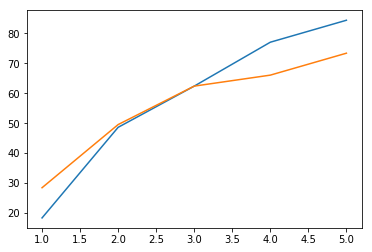

[(1, (18.35, 28.44)),
 (2, (48.62, 49.54)),
 (3, (62.39, 62.39)),
 (4, (77.06, 66.06)),
 (5, (84.4, 73.39))]

In [57]:
import matplotlib.pyplot as plt
import numpy as np


results = []

# first we calculate the max number of candidates across all the columns in the tabular data so we cap the range
max_cand = 0
for file in dict_predictions:
    for col in dict_predictions[file]:
        
        candidate_cls = set()
        for element in dict_predictions[file][col]:
            candidate_cls.add(element[0])
        if len(candidate_cls) > max_cand:
            max_cand = len(candidate_cls)

            
# the we increase the size of top list one element at a time until we reac the cap...
for i in range(1,6):
    (x,y) = (i, lookup_assessment(dict_predictions, i))
    results.append((x,y))

#... and plot the results
fig, ax = plt.subplots()
ax.plot([x[0] for x in results],[x[1] for x in results])
plt.show()
results

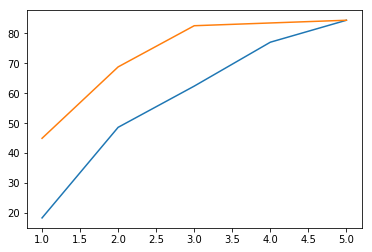

[(1, (18.35, 44.95)),
 (2, (48.62, 68.81)),
 (3, (62.39, 82.57)),
 (4, (77.06, 83.49)),
 (5, (84.4, 84.4))]

In [56]:

import matplotlib.pyplot as plt
import numpy as np


results = []

# first we calculate the max number of candidates across all the columns in the tabular data so we cap the range
max_cand = 0
for file in dict_predictions:
    for col in dict_predictions[file]:
        
        candidate_cls = set()
        for element in dict_predictions[file][col]:
            candidate_cls.add(element[0])
        if len(candidate_cls) > max_cand:
            max_cand = len(candidate_cls)

            
# the we increase the size of top list one element at a time until we reac the cap...
for i in range(1,6):
    (x,y) = (i, lookup_assessment(dict_predictions_top5, i))
    results.append((x,y))

#... and plot the results
fig, ax = plt.subplots()
ax.plot([x[0] for x in results],[x[1] for x in results])
plt.show()
results

In [41]:
# max_cand

3

In [16]:
with open(('output/dict_predictions.json'), 'w') as fp:
        json.dump(dict_predictions, fp)

{'58891288_0_1117541047012405958': {'1': {'gt': 'Film',
   'cand_cls': ['Work',
    'Film',
    'Agent',
    'WrittenWork',
    'Organisation',
    'Book',
    'Place',
    'Location',
    'MusicalWork',
    'Person',
    'PopulatedPlace',
    'Settlement',
    'Album',
    'City',
    'MusicGenre',
    'Song',
    'Company',
    'TelevisionShow',
    'PersonFunction',
    'SportsTeam',
    'Software',
    'VideoGame',
    'MeanOfTransportation',
    'SoccerClub',
    'SportsClub',
    'MilitaryUnit',
    'Writer',
    'Country',
    'Royalty',
    'RecordLabel',
    'Comic',
    'Manga',
    'Band',
    'Group',
    'ArchitecturalStructure',
    'Play',
    'Ship',
    'Event',
    'MilitaryConflict',
    'SocietalEvent',
    'TopicalConcept',
    'Genre',
    'FictionalCharacter',
    'MusicalArtist',
    'Bank',
    'AdministrativeRegion',
    'FormulaOneTeam',
    'Aircraft',
    'BasketballTeam',
    'CricketTeam',
    'University',
    'EducationalInstitution',
    'School',
    

Retrieve all folders under the cnn_models root

In [ ]:
def get_cnn_models(directory):
    temp = [x[0] for x in os.walk(directory)]
    temp.remove(directory)
    return set([x.replace(directory+'\\','').split('\\')[0] for x in temp])

trained_models = list(get_cnn_models(cnn_model_directory))
trained_models

In [ ]:
# model.summary()

In [ ]:
# results